<a href="https://colab.research.google.com/github/Alireza-Khodapanah/CNN-Based-Architectural-Component-Classification/blob/main/CNN-Based%20Architectural%20Component%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Explicitly set TensorFlow backend to use GPU
tf.config.set_soft_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
#Make directory name kaggle
! mkdir ~/.kaggle

In [ ]:
#Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#Downloading competition dataset
!kaggle datasets download -d ikobzev/architectural-heritage-elements-image64-dataset

Dataset URL: https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset
License(s): unknown
 92% 34.0M/36.8M [00:02<00:00, 19.2MB/s]
100% 36.8M/36.8M [00:02<00:00, 12.9MB/s]


In [ ]:
# Put on the same directory
from zipfile import ZipFile

# specifying the name of the zip file
file = "/content/architectural-heritage-elements-image64-dataset.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
train/dome(outer)/1296.jpg                     2022-01-10 14:58:30         5491
train/dome(outer)/1297.jpg                     2022-01-10 14:58:30         1691
train/dome(outer)/1298.jpg                     2022-01-10 14:58:30         2545
train/dome(outer)/1299.jpg                     2022-01-10 14:58:30         1873
train/dome(outer)/1300.jpg                     2022-01-10 14:58:30         3067
train/dome(outer)/1301.jpg                     2022-01-10 14:58:30         2002
train/dome(outer)/1302.jpg                     2022-01-10 14:58:30         1210
train/dome(outer)/1303.jpg                     2022-01-10 14:58:30         5107
train/dome(outer)/1304.jpg                     2022-01-10 14:58:30         3839
train/dome(outer)/1305.jpg                     2022-01-10 14:58:30         5457
train/dome(outer)/1306.jpg                     2022-01-10 14:58:30        14150
train/dome(outer)/1307.jpg                     2022-01-10 14:58:30   

In [ ]:
# Define the paths to the train and test dataset folders
train_path = '/content/train'
test_path = '/content/test'

# Define the list of categories
categories = ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)',
              'dome(outer)', 'flying_buttress', 'gargoyle',
              'stained_glass', 'vault']

# Function to load images from a folder and populate the images and labels lists
def load_images_from_folder(folder_path, categories):
    images, labels = [], []
    for i, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (100, 100))
            image = image / 255.0
            images.append(image)
            labels.append(i)
    return np.array(images), np.array(labels)

# Load train and test images
train_images, train_labels = load_images_from_folder(train_path, categories)
test_images, test_labels = load_images_from_folder(test_path, categories)

# Shuffle the data
train_indices = np.arange(len(train_images))
test_indices = np.arange(len(test_images))
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)
train_images = train_images[train_indices]
train_labels = train_labels[train_indices]
test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


In [ ]:
# Define the CNN model
def cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model



In [ ]:
# Create the CNN model
model = cnn_model(input_shape=(100, 100, 3), num_classes=len(categories))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the checkpoint callback
checkpoint_filepath = 'best_model.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True,
                                       verbose=1)

# Train the model
history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=32),
                    steps_per_epoch=len(train_images) / 32, epochs=150,
                    validation_data=(test_images, test_labels),
                    callbacks=[checkpoint])

# Load the best model saved
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Predictions on the test set
y_pred = np.argmax(best_model.predict(test_images), axis=1)


Epoch 1/150
317/316 [==============================] - ETA: 0s - loss: 1.6491 - accuracy: 0.4003
Epoch 1: val_accuracy improved from -inf to 0.57194, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


316/316 [==============================] - 41s 106ms/step - loss: 1.6491 - accuracy: 0.4003 - val_loss: 1.2185 - val_accuracy: 0.5719
Epoch 2/150
317/316 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.5773
Epoch 2: val_accuracy improved from 0.57194 to 0.58974, saving model to best_model.h5
316/316 [==============================] - 32s 102ms/step - loss: 1.2330 - accuracy: 0.5773 - val_loss: 1.1303 - val_accuracy: 0.5897
Epoch 3/150
317/316 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.6297
Epoch 3: val_accuracy improved from 0.58974 to 0.65741, saving model to best_model.h5
316/316 [==============================] - 33s 105ms/step - loss: 1.0690 - accuracy: 0.6297 - val_loss: 0.9507 - val_accuracy: 0.6574
Epoch 4/150
317/316 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.6744
Epoch 4: val_accuracy improved from 0.65741 to 0.67735, saving model to best_model.h5
316/316 [==============================] - 33s 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Example: Save model.h5 to a specific folder in Google Drive
best_model.save('/content/drive/My Drive/path/to/folder/model.h5')


Classification Report:
                 precision    recall  f1-score   support

          altar       0.85      0.91      0.88       140
           apse       0.66      0.76      0.70        50
     bell_tower       0.87      0.75      0.81       170
         column       0.86      0.88      0.87       210
    dome(inner)       0.90      0.91      0.91        69
    dome(outer)       0.85      0.90      0.87       142
flying_buttress       0.81      0.79      0.80        70
       gargoyle       0.92      0.92      0.92       240
  stained_glass       0.97      0.95      0.96       150
          vault       0.94      0.91      0.93       163

       accuracy                           0.88      1404
      macro avg       0.86      0.87      0.86      1404
   weighted avg       0.88      0.88      0.88      1404



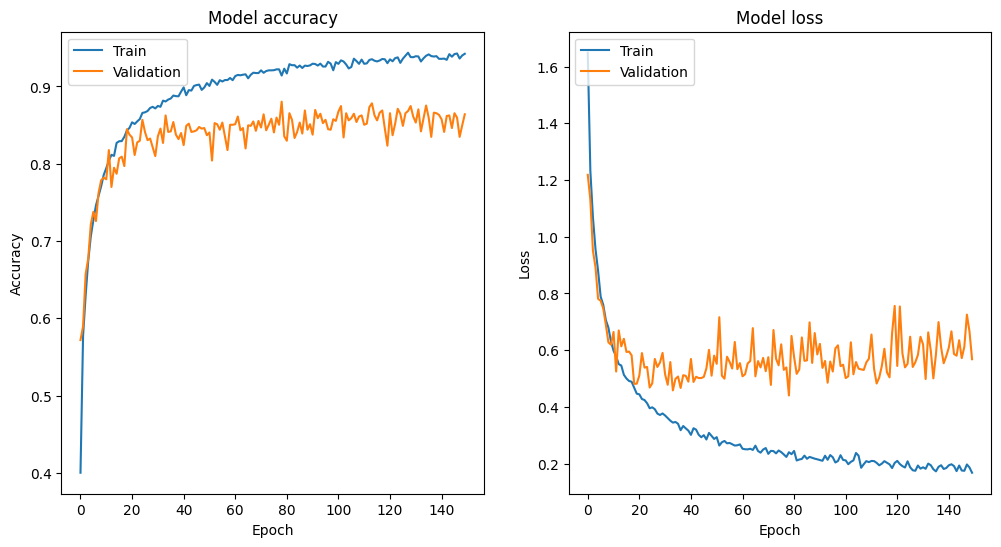

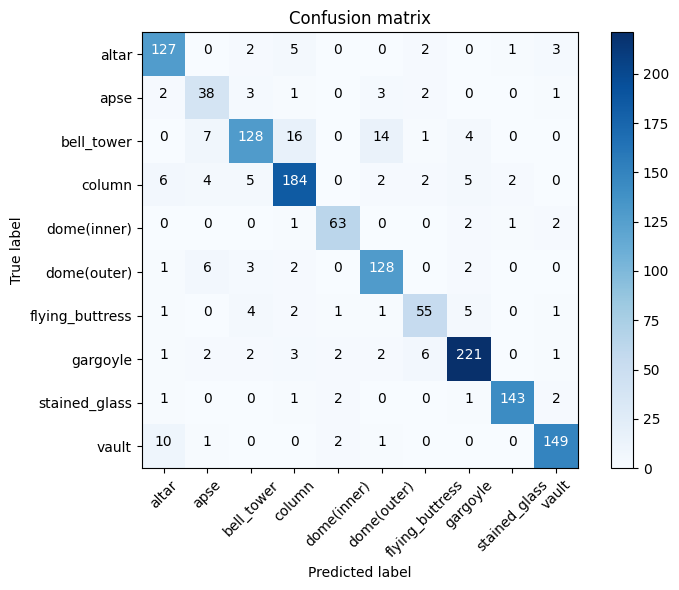

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=categories))

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Save the model
best_model.save('cnn_model.h5')